Import Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import ipywidgets as widgets
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.manifold import TSNE
from IPython.display import display, HTML

Load Data

In [2]:
df = pd.read_csv('./data/train.csv')
print(f"Dataset shape: {df.shape}")
df.head()

Dataset shape: (24783, 6)


,count,hate_speech_count,offensive_language_count,neither_count,class,tweet
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


Train Model

In [3]:
# Prep data
X = df['tweet']
y = df['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Vectorize text
tfidf = TfidfVectorizer(max_features=5000, stop_words='english')
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# Train model
model = LogisticRegression(max_iter=1000)
model.fit(X_train_tfidf, y_train)

# Evaluate and return Accuracy
y_pred = model.predict(X_test_tfidf)
print(f"Accuracy: {accuracy_score(y_test, y_pred)*100:.2f}%")

Accuracy: 89.29%


Chart 1: Distribution of Tweets by Category

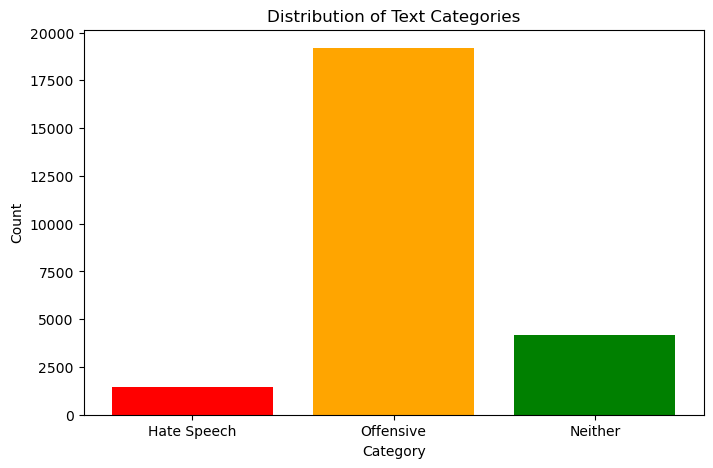

In [4]:
plt.figure(figsize=(8,5))
label_counts = df['class'].value_counts().sort_index()
labels = ['Hate Speech', 'Offensive', 'Neither']
plt.bar(label_counts.index, label_counts.values, color=['red', 'orange', 'green'])
plt.xticks([0, 1, 2], labels)
plt.title('Distribution of Text Categories')
plt.xlabel('Category')
plt.ylabel('Count')
plt.show()

Chart 2: t-SNE Visualization

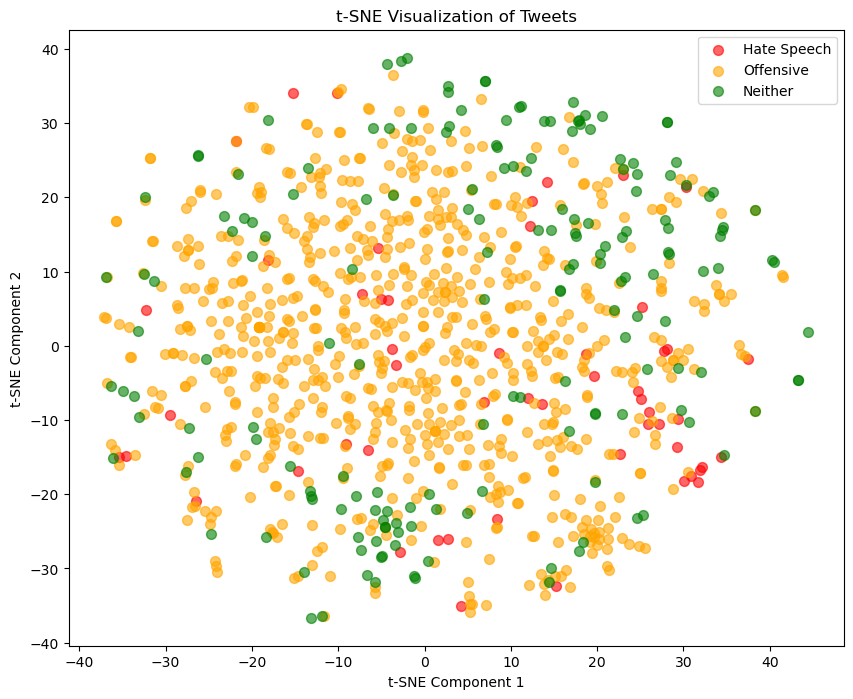

In [5]:
# Sample data
sample_size = min(1000, len(X_train))
indices = np.random.choice(X_train_tfidf.shape[0], sample_size, replace=False)
X_sample = X_train_tfidf[indices]
y_sample = y_train.iloc[indices]

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X_sample.toarray())

# Plot
plt.figure(figsize=(10,8))
colors = ['red', 'orange', 'green']
for i in range(3):
    mask = y_sample == i
    plt.scatter(X_tsne[mask, 0], X_tsne[mask, 1], c=colors[i], label=labels[i], alpha=0.6, s=50)
plt.legend()
plt.title('t-SNE Visualization of Tweets')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

Chart 3: Confusion Matrix

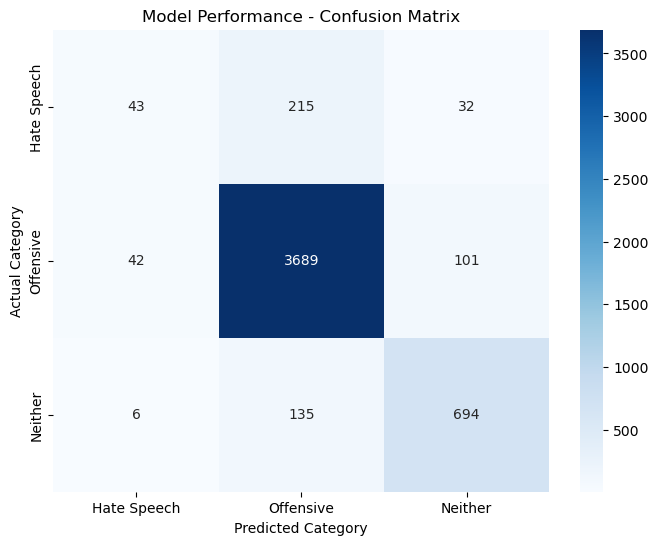

In [6]:
plt.figure(figsize=(8,6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Model Performance - Confusion Matrix')
plt.xlabel('Predicted Category')
plt.ylabel('Actual Category')
plt.show()

Hardcoded Testcases

In [7]:
# Test driver
def test_offensive(text):
    text_tfidf = tfidf.transform([text])
    prediction = model.predict(text_tfidf)[0]
    probability = model.predict_proba(text_tfidf)[0]

    labels = ['Hate Speech', 'Offensive', 'Neither']
    print(f"Text: '{text}'")
    print(f"Prediction: '{labels[prediction]}'")
    print(f"Confidence: {probability[prediction]:.2%}\n")

# Example Text

# Neither
test_offensive("Today's gonna be a great day! #blessed")

# Offensive
test_offensive("@User You're a god dang moron")

# Hate Speech
test_offensive("I'm not racist but I hate when those people do that")

Text: 'Today's gonna be a great day! #blessed'
Prediction: 'Neither'
Confidence: 62.55%

Text: '@User You're a god dang moron'
Prediction: 'Offensive'
Confidence: 57.93%

Text: 'I'm not racist but I hate when those people do that'
Prediction: 'Hate Speech'
Confidence: 87.49%



User Input

In [9]:
# Declare Widgets

text_input = widgets.Textarea(
    placeholder='Enter text to analyze...',
    description='Text:',
    layout=widgets.Layout(width='500px', height='80px')
)
button = widgets.Button(
    description='Analyze Text',
    button_style='primary',
    icon='search'
)
output = widgets.Output()

# Create display
def analyze_text(b):
    with output:
        output.clear_output()
        if text_input.value.strip():
            text_tfidf = tfidf.transform([text_input.value])
            prediction = model.predict(text_tfidf)[0]
            probability = model.predict_proba(text_tfidf)[0]

            labels = ['Hate Speech', 'Offensive', 'Neither']
            colors = ['#ff4444', '$ff8844', '#44ff44']

            result_html = f"""
            <div style="padding: 20px; border-radius: 10px; background-color: #f0f0f0;">
                <h3>Analysis Result</h3>
                <p><b>Text:</b> "{text_input.value}"</p>
                <p><b>Classification:</b> <span style="color: {colors[prediction]}; font-weight: bold; font-size: 1.2em;">{labels[prediction]}</span></p>
                <p><b>Confidence:</b> {probability[prediction]:.1%}</p>
                <div style="margin-top: 15px;">
                    <b>Probabilities:</b><br>
                    - Hate Speech: {probability[0]:.1%}<br>
                    - Offensive: {probability[1]:.1%}<br>
                    - Neither: {probability[2]:.1%}
                </div>
            </div>
            """
            display(HTML(result_html))
        else:
            print("No text entered. Please try again.")

button.on_click(analyze_text)

# Display the widget
display(widgets.VBox([
    widgets.HTML("<h3>Offensive Content Detector</h3>"),
    text_input,
    button,
    output
]))
